# Lakes

This notebook combines the analysis of notebooks `1 - 3` to produce the definitive plots


---


## 0. Global variables

First we will declare some variables, functions and useful calculations that will be shared among the sections below. If you just want to see the analysis, skip to `1.V15 vs V20`.

In [1]:
#VARIABLES

V15_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_2016_augmented/'
V20_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_augmented/'
V20_model_with_extras = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_augmented_monthlyclake/'


#If the change in a variable is greater than tolerance (e.g. abs(cl) > tolerance), the change is marked as `significant`. 
#The "is significant"/"is not significant" boolean is then used is to define a grouping bitstring category.
#For lake depth dl, tolerance specifies the fracional change e.g. is the change in dl > 10%? 
tolerance = 0.1 


In [153]:
# FUNCTIONS
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 
from scipy.stats import ttest_ind
import numpy as np
import seaborn as sns

def calculate_delta_field(filename,parameter):
    
    
    """
    Function to determine the change in a parameter when going from V15 to V20
    """
    
    root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
    version = ['v015', 'v020']
    
    ds = [] #Array to hold results
    for v in version:
        path = root+f'climate.{v}/climate.{v}/639l_2/{filename}'
        ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName':parameter}) #only want this one parameter
        
        ds.append(ds_i)
        
    #Take the difference, and make it a nice pandas df    
    delta_field = ds[1] - ds[0] #V20 - V15
    delta_field =  delta_field.assign_coords({"longitude": (((delta_field.longitude + 180) % 360) - 180)}) #long3 ---> long1
    delta_field = delta_field.to_dataframe().reset_index()
    
    V20_df = ds[1].to_dataframe().reset_index()
    V15_df = ds[0].to_dataframe().reset_index()

    if parameter == '10si': #seaice shortname is inverse to variable name
        parameter='si10'
    
    delta_field[f'V15_{parameter}'] = V15_df[parameter]
    delta_field[f'V20_{parameter}'] = V20_df[parameter]
    delta_field = delta_field.rename(columns={f'{parameter}': f'change_in_{parameter}'})
    delta_field[f'percentage_change_in_{parameter}'] = (delta_field[f'V20_{parameter}'] - delta_field[f'V15_{parameter}']) / delta_field[f'V15_{parameter}']

    return delta_field


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize,savefig):
    
    """Hacky function plotting the value of `z` at latitude/longitude points
       as a scatter map"""

    try:
        x = ds.longitude
        y = ds.latitude
    except: # different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.Robinson(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title,fontsize=30)    
    ax.coastlines()

    
    #ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])
        
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)

    plt.show()
    
    
    
    
    
    
    
    
    
    
def load_predictions(model):

    """For this model, load the predictions and determine the prediction error"""
    
    df = pd.read_parquet(model+'predictions.parquet')
    
    #Calculate some extra columns
    df['predicion_bias'] = df.MODIS_LST - df.predictions
    df['predicion_error'] = abs(df.MODIS_LST - df.predictions)


    print("Mean/Median/Std prediction bias:", df['predicion_bias'].mean(), df['predicion_bias'].median(),df['predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['predicion_error'].mean(), df['predicion_error'].median(),df['predicion_error'].std())

    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 


    return df,df_grouped



def plot_distribution(df,x,xlabel):
    

    """Plot the distribution of the quantity `x` in df """

    #Setup plot env
    h,w = 20,20
    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    sns.histplot(df[x], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0')

    # Config
    ax1.set_xlabel(xlabel)

    ax1.axvline(0,c='0.5', linestyle='--')
    
    #Prints
    print ('Number of samples:', len(df))
    print ('Distribution Mean/Median:', df[x].mean(), df[x].median())

    plt.show()
    
    
    
    
    
    
    
#-------------------------------------
    
def classify(x,tol):
    
    if abs(x) > tol:
        return True
    else:
        return False
    
def classify_dl(x,tol):
    
    if abs(x) > tol:
        return True
    else:
        return False
    
    
        
def bit(x):
    
    if x:
        return 1
    else:
        return 0


def bitstring(list_of_columns):
    
    bitstring=''
    for i in list_of_columns:
        idx = bit(i)
        bitstring += str(idx)
        
    return bitstring
    
#-------------------------------------
    
def significance_test(v1,v2):
    try:
        return ttest_ind(v1, v2)
    except:
        return np.nan

def significance_boolean(x):
    
    try:
        pval = x[-1]
    except:
        #Nans are not subscriptable
        return 'Insignificant'
    
    if (pval > 0.01) or np.isnan(pval): 
        return 'Insignificant'
    else:
        return 'Significant'
    
    

    
    




def RobinsonPlot(df,z,vmin,vmax,cmap,markersize,savefig):


    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
    cax = fig.add_axes([0.32, 0.10, 0.4, 0.0125])

    #Get data
    x = df['latitude_ERA']
    y = df['longitude_ERA']
    z1 = df[z]
    
    
    #Normalise
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    #Colorbar
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                               norm=norm,
                               orientation='horizontal'
                               )
    #Scatter points
    sc = ax.scatter(y,x,transform=ccrs.PlateCarree(),
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)


    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    #Formatting
    cax.tick_params(labelsize=16)
    cax.set_xlabel('K',fontsize=16)

    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio
    #ax.set_xlim(-180,180)

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)    
    
    
    
    
    

    
    
    

In [3]:
#CALCULATIONS

#Calculate all the delta fields i.e. the change in parameter V15-->V20
clake_delta_field  = calculate_delta_field('clake','cl')        #How does cl change?
seaice_delta_field = calculate_delta_field('cicecap','10si')    #How does seaice change
cvh_delta_field    = calculate_delta_field('cvh','cvh')         #How does cvh change?
cvl_delta_field    = calculate_delta_field('cvl','cvl')         #How does cvl change
lsm_delta_field    = calculate_delta_field('lsmoro','lsm')      #How does lsm change?
dl_delta_field     = calculate_delta_field('lakedl','dl')      #How does lake depth change?

#Bring all the delta fields together
change_in_fields = pd.concat([clake_delta_field,seaice_delta_field,cvh_delta_field,cvl_delta_field,lsm_delta_field,dl_delta_field],axis=1)
change_in_fields = change_in_fields.loc[:,~change_in_fields.columns.duplicated()] #remove duplicated column names that arise due to the concat


# Classify every grid point according to the delta fields
# First create extra boolean columns for whether the change in the field is significant, where significane is determined by `tolerance`     
for parameter in ['cl','si10','cvh','cvl','lsm']:
    change_in_fields[f'{parameter}_change_is_significant'] = change_in_fields.apply(lambda x : classify(x[f'change_in_{parameter}'],tolerance), axis = 1)
    
#handle dl separatley since this is not a fractional 0-1 features
change_in_fields[f'dl_change_is_significant'] = change_in_fields.apply(lambda x : classify_dl(x[f'change_in_dl']/x[f'V15_dl'],tolerance), axis = 1)
    

    
# Then create a single group bitstring for all combinations of booleans
change_in_fields[f'bitstring'] = change_in_fields.apply(lambda x : bitstring( [x['cl_change_is_significant'],
                                                                               x['cvh_change_is_significant'],
                                                                               x['cvl_change_is_significant'],
                                                                               x['dl_change_is_significant'],
                                                                               x['lsm_change_is_significant'],
                                                                               x['si10_change_is_significant']    # ALPHABETICAL
                                                                              ]
                                                                               ), axis = 1)

In [4]:
display_table = change_in_fields.groupby(['bitstring']).count()[['values']]
display_table = display_table.rename(columns={"values": "Number of Pixels"})
display(display_table.sort_values(by='Number of Pixels',ascending=False))

,Number of Pixels
bitstring,
000000,362608
000100,170901
000101,2661
100100,2488
100110,1715
000110,489
000111,359
100000,240
100010,119


---


## 1. Load all data

In [396]:
V15_predictions,V15_predictions_averaged = load_predictions(V15_model)
V20_predictions,V20_predictions_averaged = load_predictions(V20_model)
V20X_predictions,V20X_predictions_averaged = load_predictions(V20_model_with_extras)

Mean/Median/Std prediction bias: -0.041747708 0.10055542 4.081224
Mean/Median/Std prediction error: 3.0393808 2.3208313 2.7240207
Mean/Median/Std prediction bias: 0.13015294 0.26712036 4.0542684
Mean/Median/Std prediction error: 3.0233936 2.3095398 2.7042806
Mean/Median/Std prediction bias: 0.018071566 0.15356445 3.9607246
Mean/Median/Std prediction error: 2.9511783 2.2535706 2.6416352


# 2. Global Maps

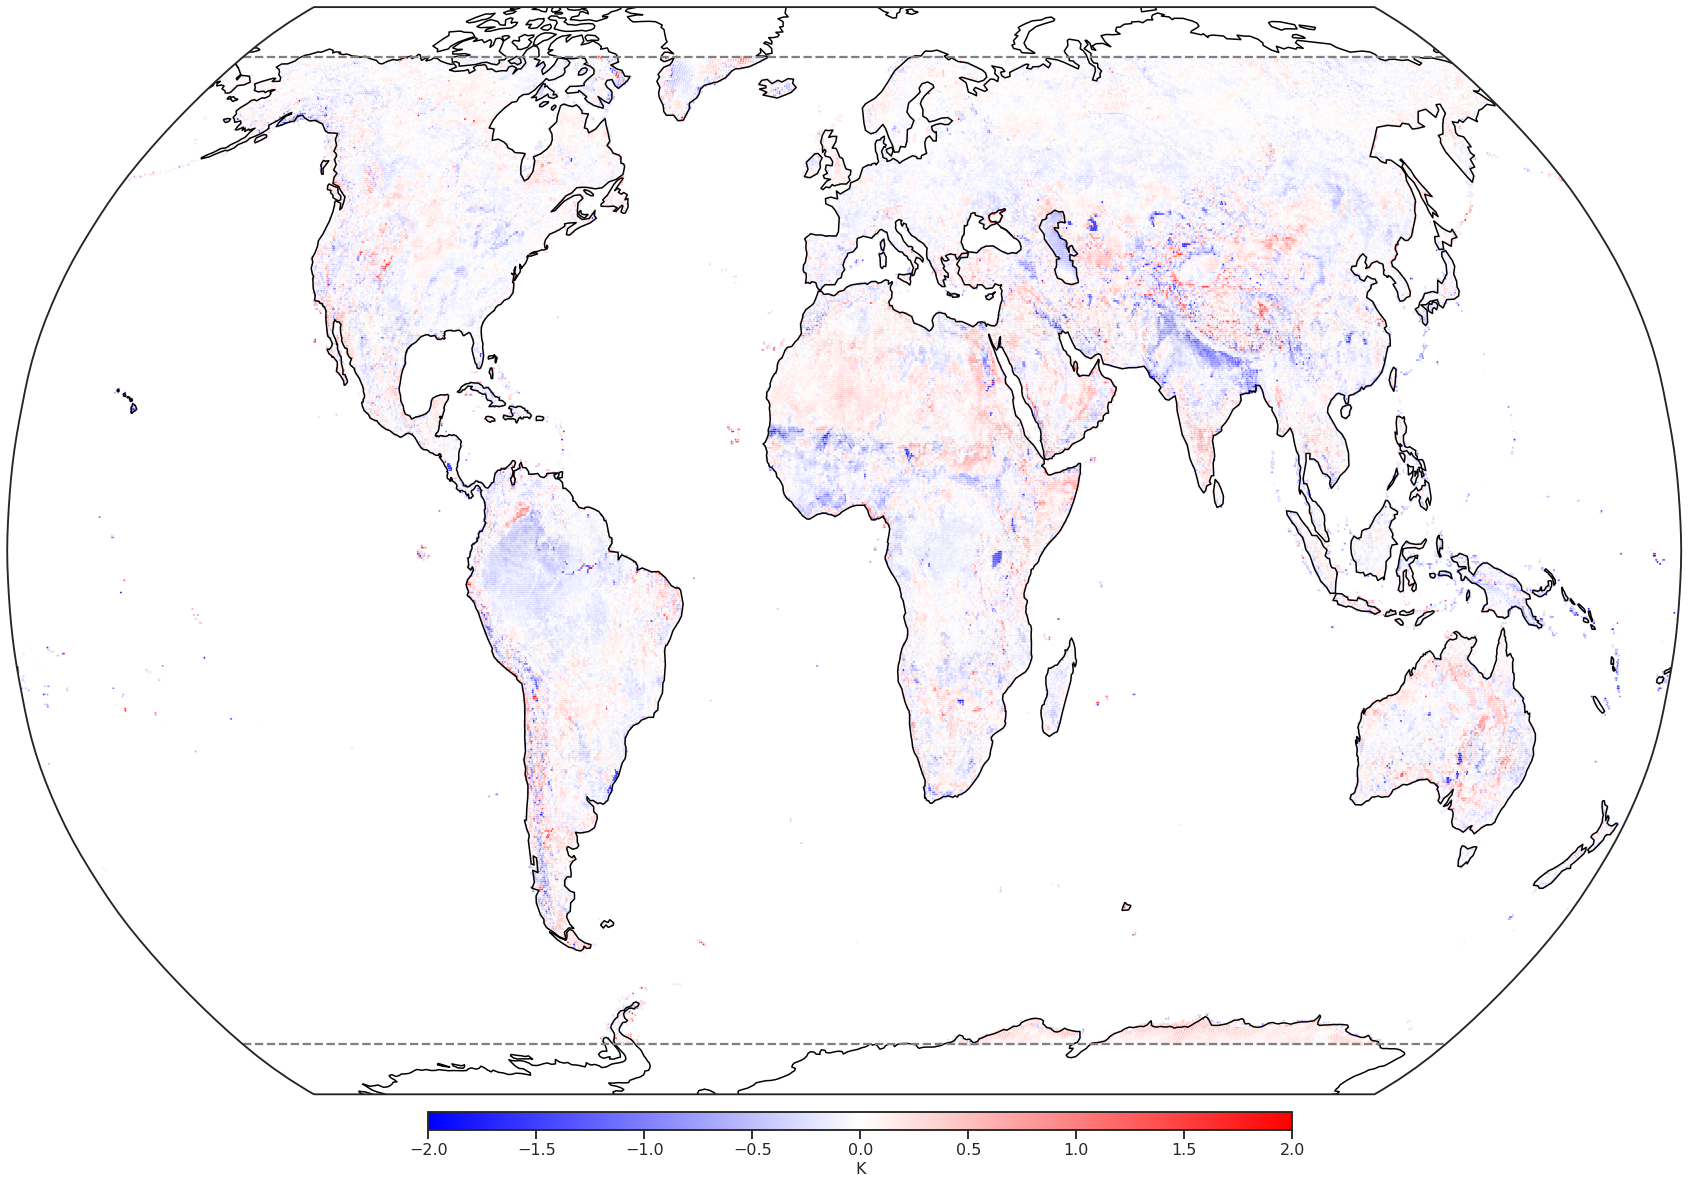

In [397]:
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_predictions_averaged.latitude_ERA, 
        'longitude_ERA':  V20_predictions_averaged.longitude_ERA,
        'MODIS_LST':      V20_predictions_averaged.MODIS_LST,
        'V15_prediction': V15_predictions_averaged.predictions,
        'V20_prediction': V20_predictions_averaged.predictions,
        'V15_error':      V15_predictions_averaged.predicion_error,
        'V20_error':      V20_predictions_averaged.predicion_error,
        'delta':          V20_predictions_averaged.predicion_error - V15_predictions_averaged.predicion_error}
V20_V15 = pd.DataFrame(data)    
RobinsonPlot(V20_V15,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,markersize = 1,savefig='figures/V20_V15_global.png')

,latitude_ERA,longitude_ERA,MODIS_LST,V15_prediction,V20_prediction,V15_error,V20_error,delta,values,step,...,V15_dl,V20_dl,percentage_change_in_dl,cl_change_is_significant,si10_change_is_significant,cvh_change_is_significant,cvl_change_is_significant,lsm_change_is_significant,dl_change_is_significant,bitstring
1,-54.660397,-70.312500,274.031128,272.249329,270.661591,4.143693,5.125044,0.981351,491141,0 days,...,6.428711,15.541992,1.417591,True,True,False,False,False,True,100101
5,-54.660397,-36.093750,271.454620,270.467804,266.600952,4.516008,6.583639,2.067630,491214,0 days,...,13.923828,39.291992,1.821925,True,True,False,False,False,True,100101
7,-54.379367,-36.562500,273.562805,271.089203,267.196381,6.018316,7.849595,1.831279,490445,0 days,...,40.315430,20.394531,-0.494126,True,True,False,False,False,True,100101
14,-52.693186,-72.900000,277.034546,275.743408,277.113007,3.578298,3.189153,-0.389144,485593,0 days,...,25.000000,27.883789,0.115352,True,True,False,False,False,True,100101
23,-51.569065,-73.333333,277.498993,274.185822,274.652344,4.503021,4.402667,-0.100354,482295,0 days,...,25.000000,16.791992,-0.328320,True,True,False,False,False,True,100101
27,-51.007004,-73.333333,273.230408,272.378662,272.533081,4.805091,4.219097,-0.585995,480567,0 days,...,150.000000,32.694336,-0.782038,True,True,False,False,True,True,100111
29,-50.444944,-73.333333,273.784515,275.842834,271.617798,3.963232,4.091616,0.128384,478839,0 days,...,150.000000,111.950195,-0.253665,True,False,False,False,True,True,100110
30,-50.163913,-72.500000,283.271240,281.066132,281.106873,3.303721,3.151254,-0.152467,477977,0 days,...,150.000000,150.000000,0.000000,True,False,False,False,True,False,100010
31,-50.163913,-72.083333,286.019104,285.284698,283.472351,2.565713,3.341119,0.775406,477978,0 days,...,150.000000,146.290039,-0.024733,True,False,False,False,True,False,100010


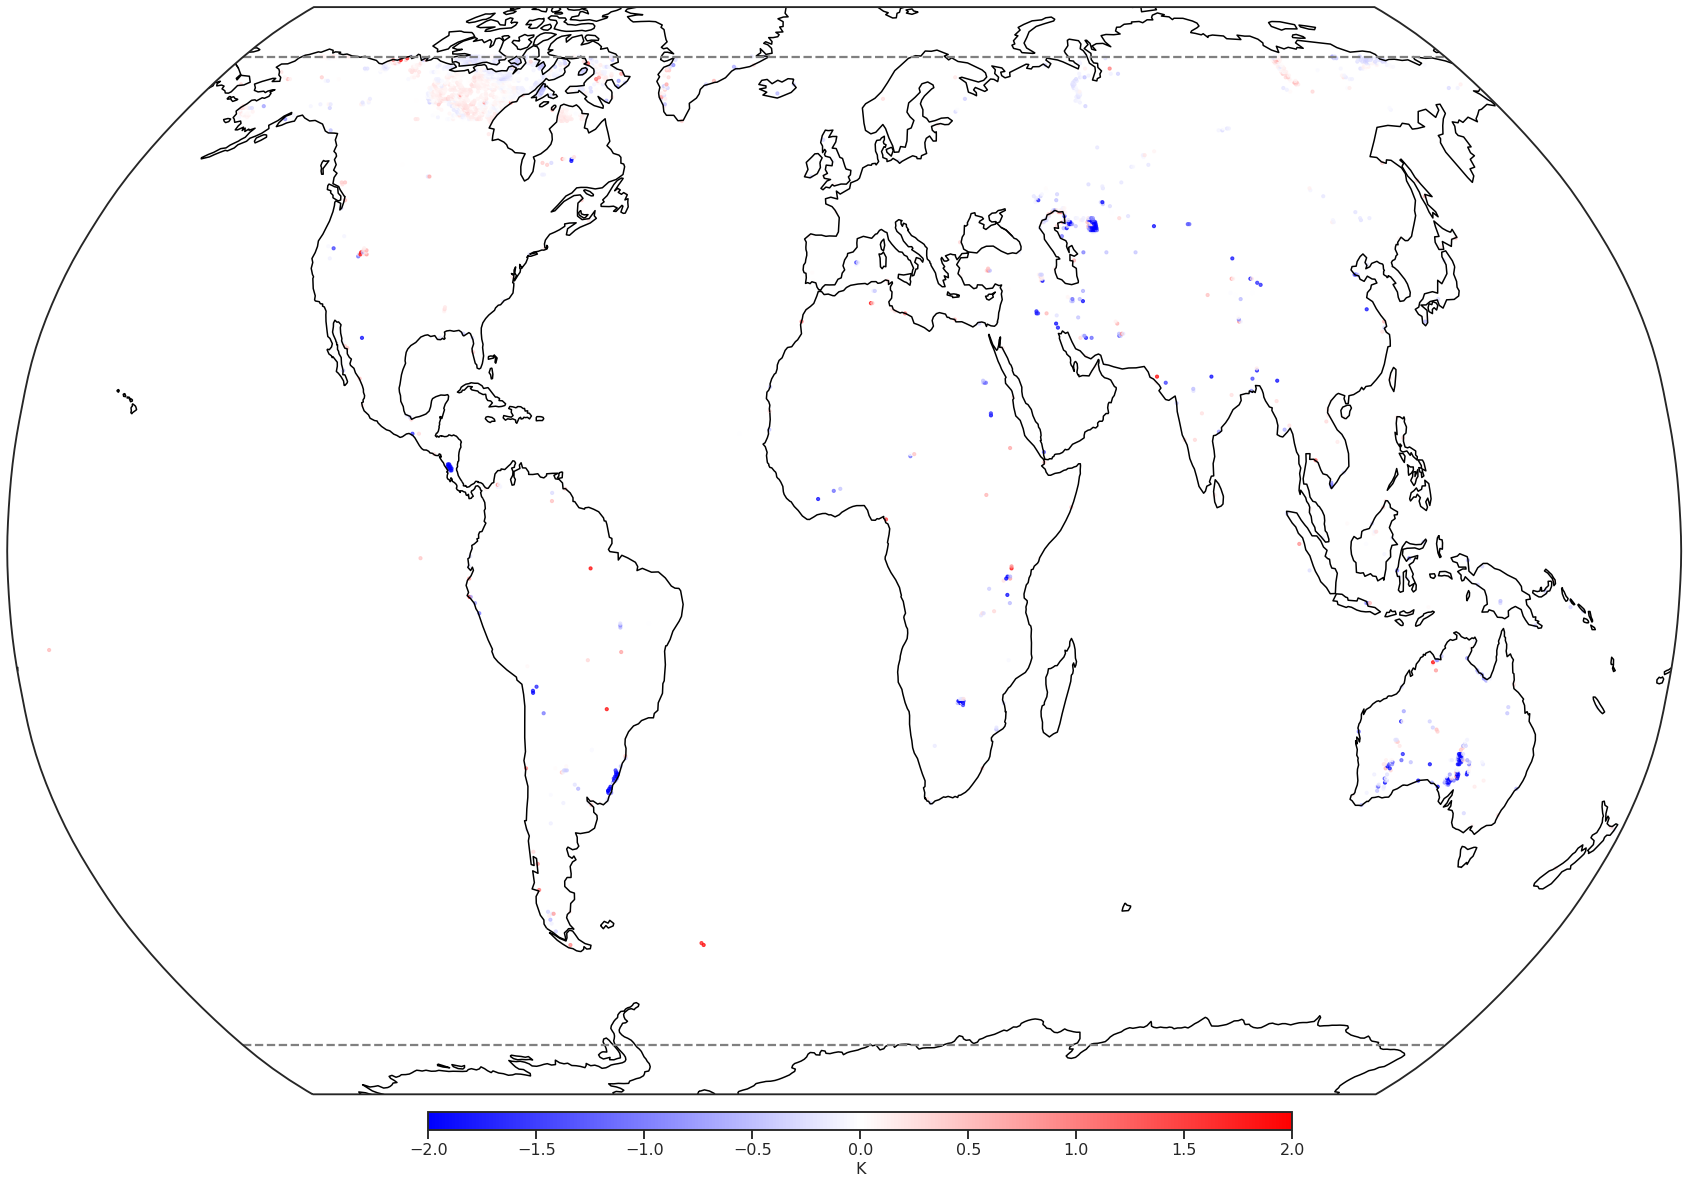

In [398]:
p = 0.1
mask_01 = change_in_fields.query(f'abs(change_in_cl) > {p}')

#Apply the mask to the global error_delta_field from earlier
V20_V15_masked_01 = pd.merge(V20_V15,mask_01,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.


saved_points = V20_V15_masked_01.query('-35 < latitude_ERA < -27 & -60 < longitude_ERA < -45')
no_costal_points = V20_V15_masked_01.query('bitstring != "100100"')

example_data_01 = pd.concat([no_costal_points,saved_points])

RobinsonPlot(example_data_01,
         'delta',
         vmin=-2,vmax=+2,
         cmap= plt.cm.bwr,
         markersize=10,
         savefig='figures/V20_V15_global_p01.png')
display(example_data_01.query('latitude_ERA < -50'))



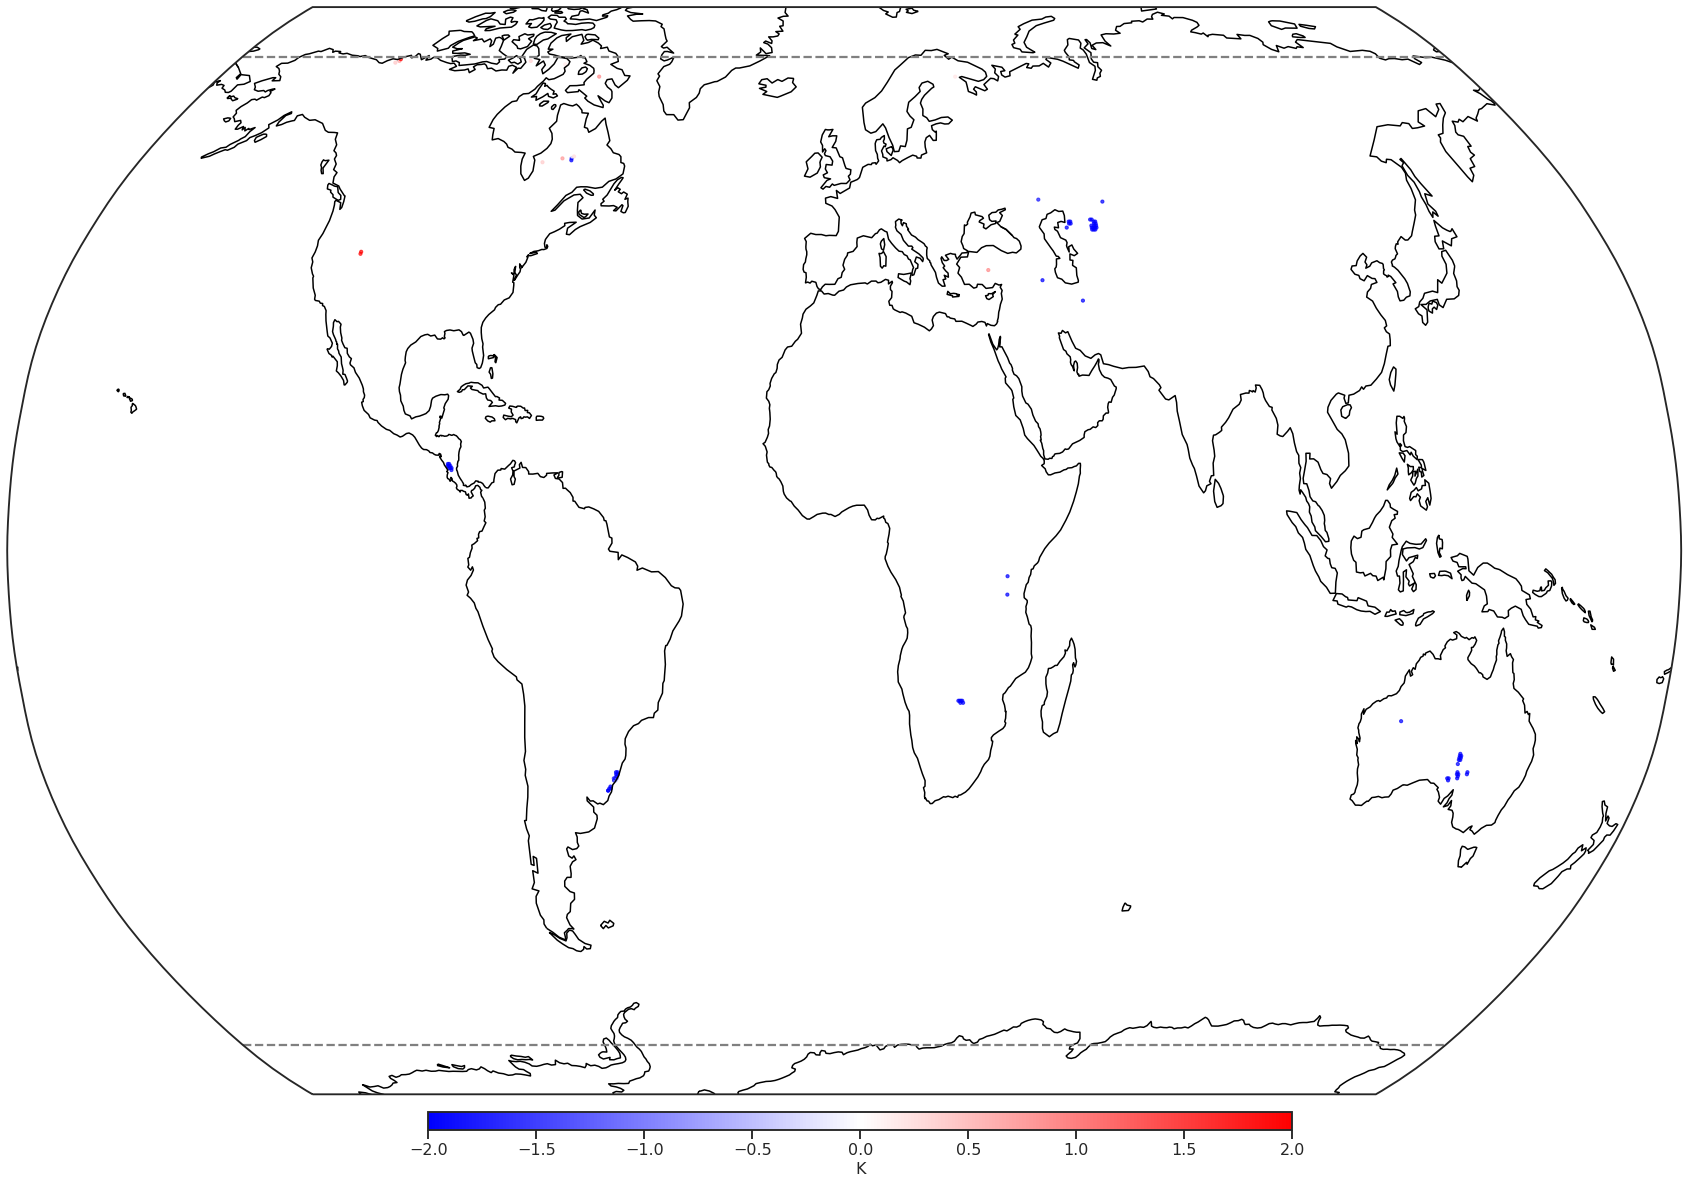

In [399]:
p = 0.5
mask = change_in_fields.query(f'abs(change_in_cl) > {p}')

#Apply the mask to the global error_delta_field from earlier
V20_V15_masked = pd.merge(V20_V15,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.


saved_points = V20_V15_masked.query('-35 < latitude_ERA < -27 & -60 < longitude_ERA < -45')
no_costal_points = V20_V15_masked.query('bitstring != "100100"')

example_data = pd.concat([no_costal_points,saved_points])



false_data = {'latitude_ERA':   [0.0,0.0] ,
              'longitude_ERA': [-179.9,179.9],
              'delta':          [0.0,0.0]}
false_df = pd.DataFrame(false_data,index=[0,1]) #Forces plot to not attenuate at edges
plotting_data = pd.concat([example_data,false_df])



RobinsonPlot(plotting_data,
         'delta',
         vmin=-2,vmax=+2,
         cmap= plt.cm.bwr,
         markersize=10,
         savefig='figures/V20_V15_global_p05.png')


# 3. Local Maps

In [263]:
import cartopy.feature as cfeature
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'

pathV20 = root+f'climate.v020/climate.v020/639l_2/clake'   
ds_clV20= xr.open_dataset(pathV20,engine='cfgrib',backend_kwargs={'indexpath': ''}) 
ds_clV20 = ds_clV20.assign_coords({"longitude": (((ds_clV20.longitude + 180) % 360) - 180)})
df_clV20 = ds_clV20.to_dataframe()




pathV15 = root+f'climate.v015/climate.v015/639l_2/clake'   
ds_clV15= xr.open_dataset(pathV15,engine='cfgrib',backend_kwargs={'indexpath': ''}) 
ds_clV15 = ds_clV15.assign_coords({"longitude": (((ds_clV15.longitude + 180) % 360) - 180)})
df_clV15 = ds_clV15.to_dataframe()

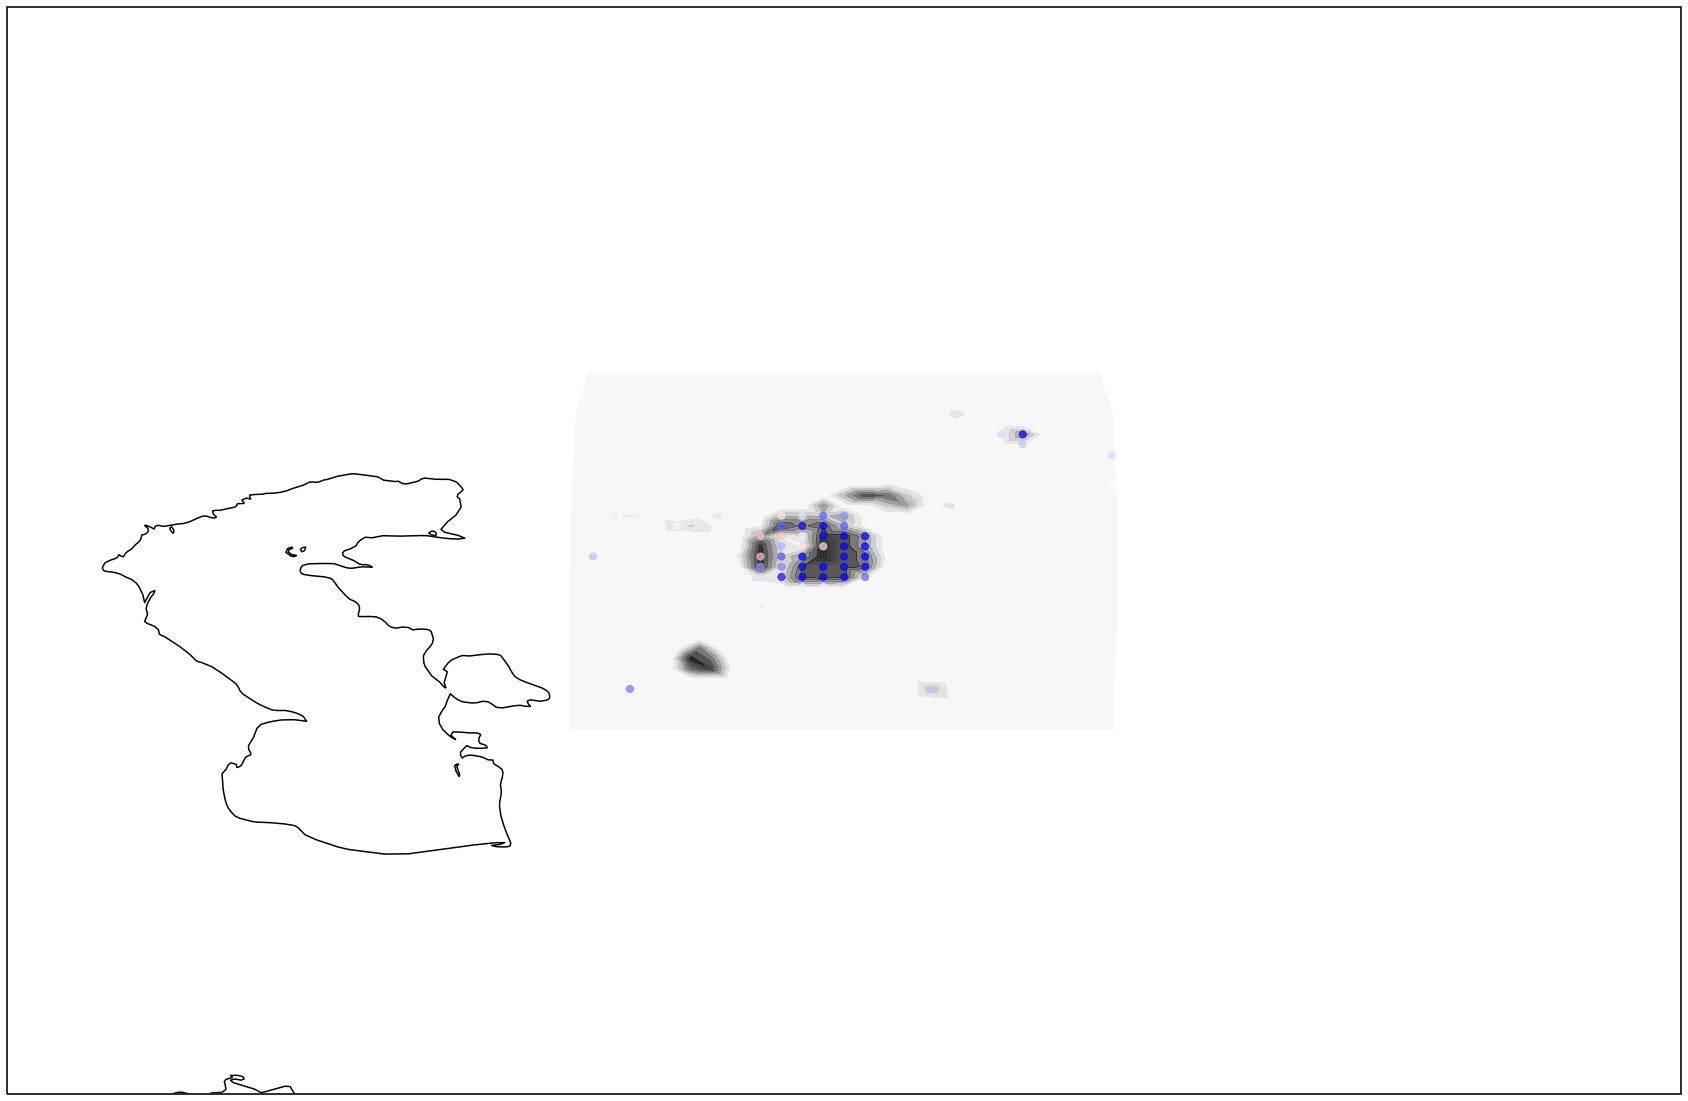

In [411]:
#Set the bounding box
lower_x = 55
upper_x = 65
lower_y = 40
upper_y = 50


#Subselect points in this area
Aral_sea = example_data_01.query(f'{lower_y} < latitude_ERA < {upper_y} & {lower_x} < longitude_ERA < {upper_x}')
df_cl_aralV20 = df_clV20.copy().query(f'{lower_y} < latitude < {upper_y} & {lower_x} < longitude < {upper_x}')
df_cl_aralV15 = df_clV15.copy().query(f'{lower_y} < latitude < {upper_y} & {lower_x} < longitude < {upper_x}')


#Setup figure and axes
fig = plt.figure(figsize=[30,20])
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines() 


#Plot cl

x = df_cl_aralV20['longitude']
y = df_cl_aralV20['latitude']
z1 = df_cl_aralV20['cl']
tr = ax.tricontourf(x, y, z1,cmap=plt.cm.Greys,alpha=.7)


x = df_cl_aralV15['longitude']
y = df_cl_aralV15['latitude']
z1 = df_cl_aralV15['cl']
tr = ax.tricontourf(x, y, z1,cmap=plt.cm.Greys,alpha=.7)


#Plot improvement
x = Aral_sea['longitude_ERA']
y = Aral_sea['latitude_ERA']
z1 = Aral_sea['delta']
cmap = plt.cm.bwr
norm = mc.Normalize(vmin=-2, vmax=2)
sc=ax.scatter(x,y,s=50,c=cmap(norm(z1)),
            linewidths=1, alpha=.7)



ax.set_global()

#border_colors = 'black'
#ax.add_feature(cfeature.COASTLINE, edgecolor=border_colors)
#ax.add_feature(cfeature.BORDERS, edgecolor=border_colors)
#ax.gridlines()
#ax.stock_img()

ax.set_xlim(lower_x-10,upper_x+10)
ax.set_ylim(lower_y-10,upper_y+10)

ax.set_aspect('auto') #Force projection aspect ratio











# 4. Timeseries

In [427]:
#Bring all relevant data into one df
data_t = {'latitude_ERA':    V20_predictions.latitude_ERA, 
          'longitude_ERA':   V20_predictions.longitude_ERA,
          'time':            V20_predictions.time,
          'V15_error':       V15_predictions.predicion_error,
          'V20_error':       V20_predictions.predicion_error,
          'V20X_error':      V20X_predictions.predicion_error}
V20_V15_t = pd.DataFrame(data_t)   
V20_V15_t['month'] = pd.DatetimeIndex(V20_V15_t.time).month
V20_V15_t['day'] = pd.DatetimeIndex(V20_V15_t.time).date

In [404]:
# Mask
p = 0.5
mask = change_in_fields.query(f'abs(change_in_cl) > {p}')
V20_V15_masked_monthly = pd.merge(V20_V15_t,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

saved_points = V20_V15_masked_monthly.query('-35 < latitude_ERA < -27 & -60 < longitude_ERA < -45')
no_costal_points = V20_V15_masked_monthly.query('bitstring != "100100"')

monthly_p05 = pd.concat([no_costal_points,saved_points])



In [405]:
monthly_p05['month_string'] = monthly_p05.month.astype(str)
monthly_p05['day_string'] = monthly_p05.day.astype(str)

In [406]:
xx = []
yy_V15 = []
yy_V20 = []
yy_V20X = []
#for m in np.unique(monthly_p05.ms):
#for m in sorted(np.unique(monthly_p05.month)):
for m in range(1,12+1):
    print(m)
    month_of_data = monthly_p05.query(f'month == {m}')
    monthly_mean = month_of_data.groupby(['month'],as_index=False).mean() 
    xx.append(m)
    yy_V15.append(monthly_mean.V15_error)
    yy_V20.append(monthly_mean.V20_error)
    yy_V20X.append(monthly_mean.V20X_error)

 


1
2
3
4
5
6
7
8
9
10
11
12


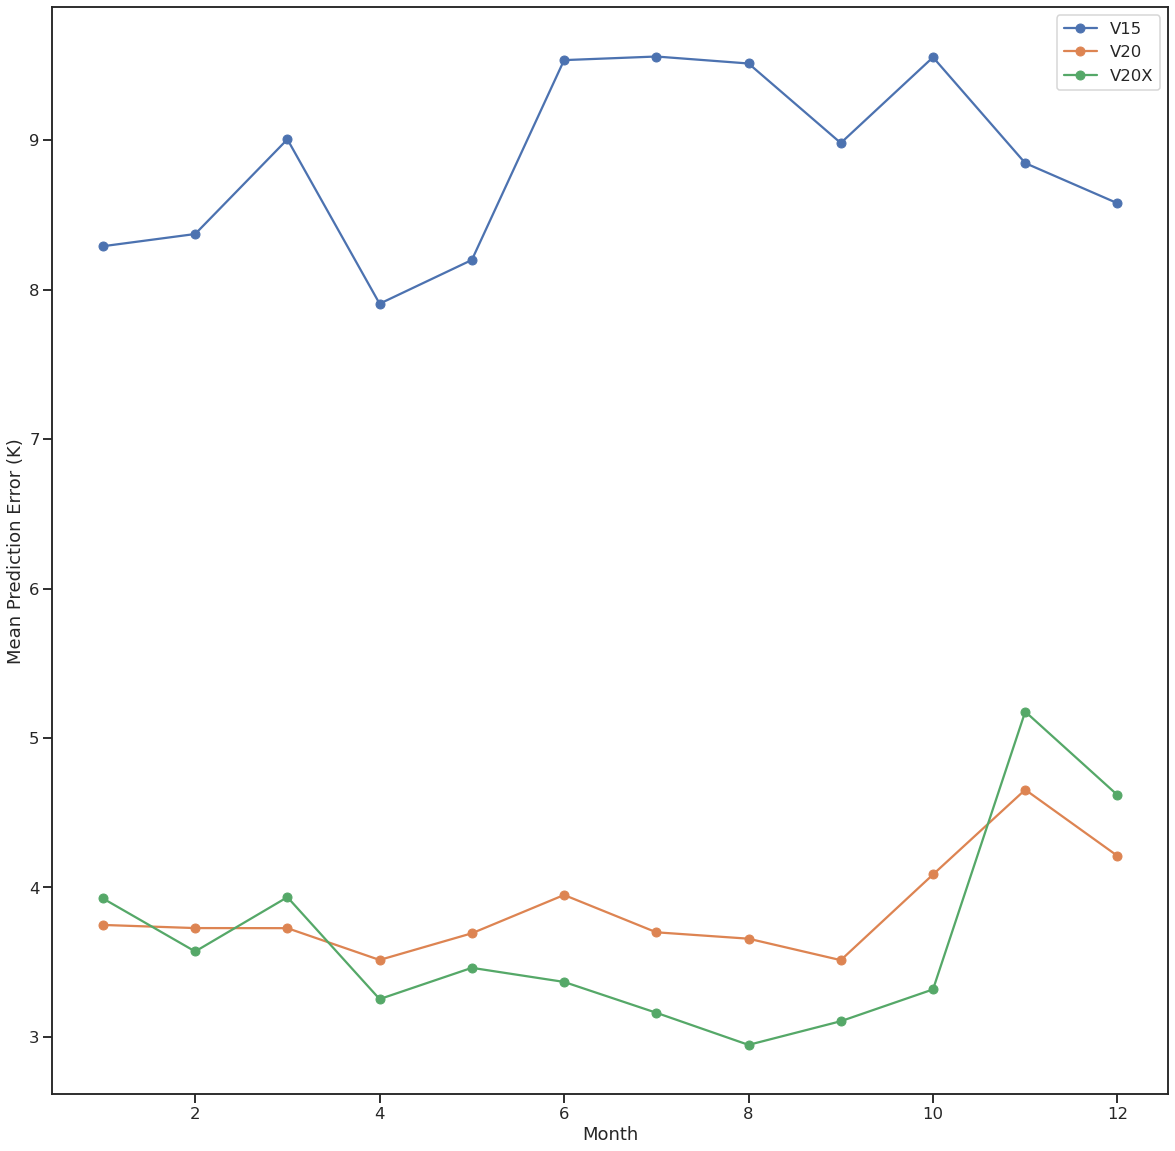

In [407]:
 #Setup plot configuration
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))


ax1.plot(xx,yy_V15,marker='o', label='V15')
ax1.plot(xx,yy_V20,marker='o', label='V20')
ax1.plot(xx,yy_V20X,marker='o', label='V20X')



# #Plot the timeseries
# p = sns.lineplot(data=df_averaged, x="years", y='temperature', hue="precision",ax=ax1,style='precision',markers=True)

# #Plot the residuals
# q = sns.lineplot(data=df_residuals, x="years", y='MBE', hue="precision",ax=ax2,style='precision',markers=False,legend=None)

# #Config
# plt.subplots_adjust(wspace=0.1, hspace=0)

ax1.set_xlabel("Month")
ax1.set_ylabel("Mean Prediction Error (K)")
ax1.legend()
savefig='figures/Timeseries_p05.png'
plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)   

---

In [428]:
# Mask
p = 0.1
mask = change_in_fields.query(f'abs(change_in_cl) > {p}')
V20_V15_masked_monthly = pd.merge(V20_V15_t,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

saved_points = V20_V15_masked_monthly.query('-35 < latitude_ERA < -27 & -60 < longitude_ERA < -45')
no_costal_points = V20_V15_masked_monthly.query('bitstring != "100100"')

monthly_p01 = pd.concat([no_costal_points,saved_points])



In [437]:
monthlyV15 = monthly_p01[['latitude_ERA','longitude_ERA', 'month', 'V15_error']].copy()
monthlyV15 = monthlyV15.rename(columns={'V15_error':'error'})
monthlyV15['model'] = 'V15'

monthlyV20 = monthly_p01[['latitude_ERA','longitude_ERA', 'month', 'V20_error']].copy()
monthlyV20 = monthlyV20.rename(columns={'V20_error':'error'})
monthlyV20['model'] = 'V20'

monthlyV20X = monthly_p01[['latitude_ERA','longitude_ERA', 'month', 'V20X_error']].copy()
monthlyV20X = monthlyV20X.rename(columns={'V20X_error':'error'})
monthlyV20X['model'] = 'V20X'

In [438]:
dfs_monthly = pd.concat([monthlyV15, monthlyV20, monthlyV20X])
display(dfs_monthly)

,latitude_ERA,longitude_ERA,month,error,model
4573,60.281000,-150.933333,1,3.122223,V15
4574,60.281000,-150.933333,1,5.310364,V15
4575,60.281000,-150.933333,1,6.526459,V15
4576,60.281000,-150.933333,1,2.064575,V15
4577,60.281000,-150.933333,1,5.540253,V15
...,...,...,...,...,...
1020771,-31.896945,-51.840000,12,3.682861,V20X
1020772,-31.896945,-51.840000,12,0.122864,V20X
1020773,-31.896945,-51.840000,12,10.274200,V20X
1020774,-31.896945,-51.840000,12,4.505920,V20X


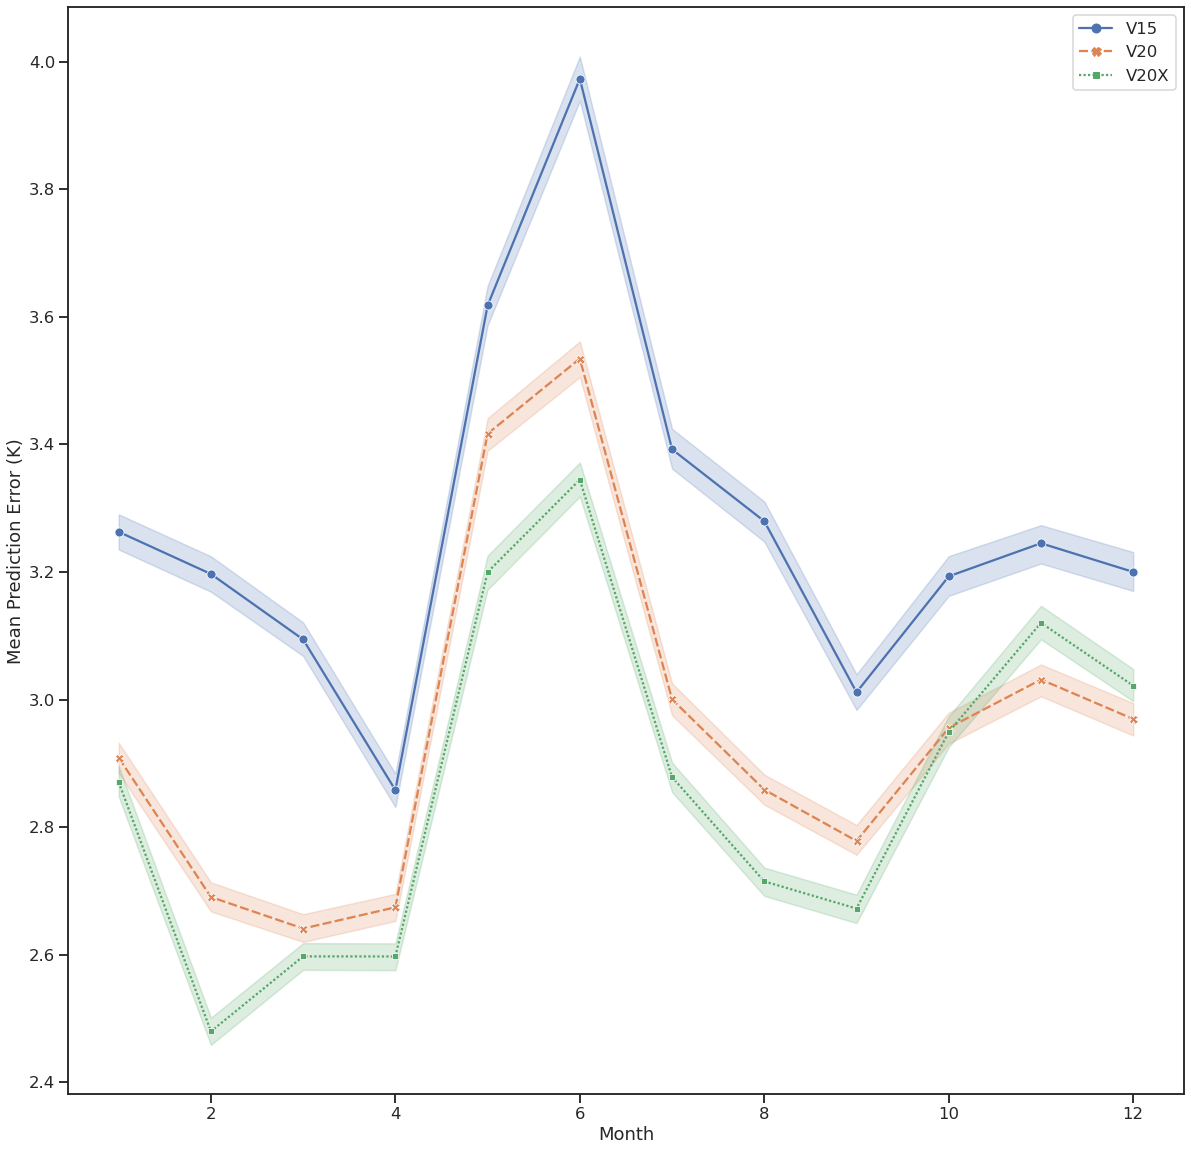

In [447]:
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))

p = sns.lineplot(data=dfs_monthly.reset_index(), x="month", y='error',hue='model', style='model', ax=ax1,markers=True)
ax1.set_xlabel("Month")
ax1.set_ylabel("Mean Prediction Error (K)")
ax1.legend().set_title(None)
savefig='figures/Timeseries_p01.png'
plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)   

In [409]:
xx = []
yy_V15 = []
yy_V20 = []
yy_V20X = []

for m in range(1,12+1):
    print(m)
    month_of_data = monthly_p01.query(f'month == {m}')
    monthly_mean = month_of_data.groupby(['month'],as_index=False).mean() 
    xx.append(m)
    yy_V15.append(monthly_mean.V15_error)
    yy_V20.append(monthly_mean.V20_error)
    yy_V20X.append(monthly_mean.V20X_error)


1
2
3
4
5
6
7
8
9
10
11
12


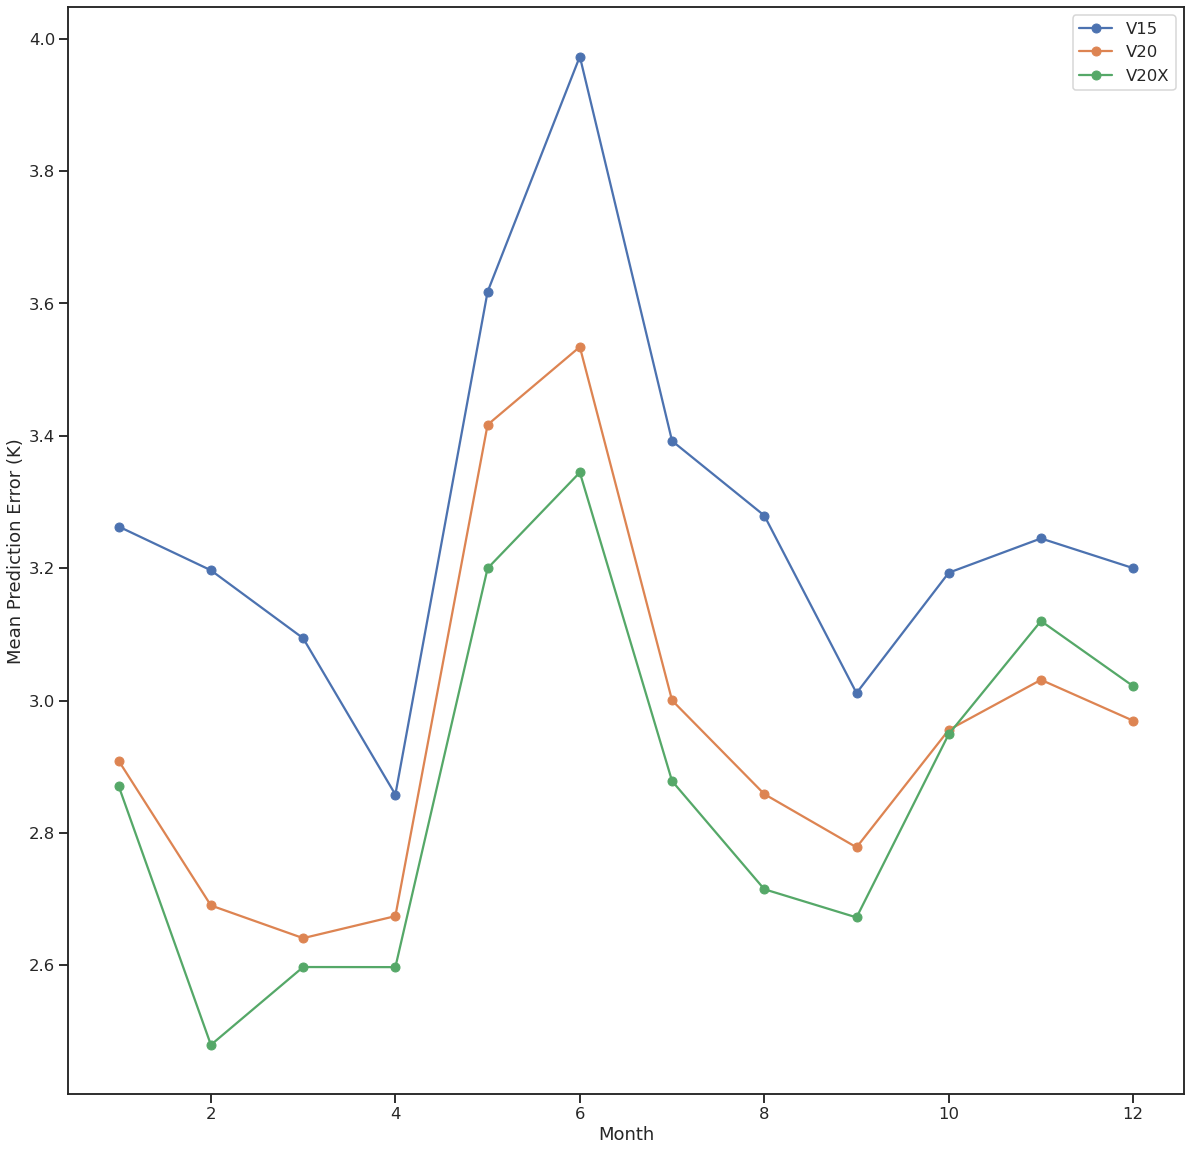

In [410]:
 #Setup plot configuration
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))


ax1.plot(xx,yy_V15,marker='o', label='V15')
ax1.plot(xx,yy_V20,marker='o', label='V20')
ax1.plot(xx,yy_V20X,marker='o', label='V20X')



ax1.set_xlabel("Month")
ax1.set_ylabel("Mean Prediction Error (K)")
ax1.legend()
savefig='figures/Timeseries_p01.png'
plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)   

# 5. Categories

In [394]:



p = 0.5
mask = change_in_fields.query(f'abs(change_in_cl) > {p}')

#Apply the mask to the global error_delta_field from earlier
V20_V15_masked = pd.merge(V20_V15,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.


saved_points = V20_V15_masked.query('-35 < latitude_ERA < -27 & -60 < longitude_ERA < -45')
no_costal_points = V20_V15_masked.query('bitstring != "100100"')

example_data = pd.concat([no_costal_points,saved_points])
V20_V15_masked = example_data.copy()

#Classification table. For each group/bitstring surface some numbers
classification_table                                = V20_V15_masked.groupby('bitstring').agg(**{'Number of Pixels':pd.NamedAgg('delta','size'),'AverageDelta':pd.NamedAgg('delta','mean')})     # For each group, count number of pixels and get the average delta      
classification_table["Percentage"]                  = 100.0* classification_table['Number of Pixels'] / sum(classification_table["Number of Pixels"])                                            # Express number of pixels as a percentage
classification_table['Stats (t-statistic,p-value)'] = V20_V15_masked.groupby('bitstring').apply(lambda x: significance_test(x['V15_error'], x['V20_error']))                                     # For each group, do a ttest between the V15_errors and the V20_errors
classification_table['Significant Change?']         = classification_table['Stats (t-statistic,p-value)'].apply(lambda x: significance_boolean(x))
print('Classification table: p = 0.5')
display(classification_table[['Number of Pixels', 'Percentage','AverageDelta','Stats (t-statistic,p-value)','Significant Change?']].sort_values(by=['Number of Pixels'],ascending=False))
print ('-----------------------------------------------------------')

    
    
    

Classification table: p = 0.5


,Number of Pixels,Percentage,AverageDelta,"Stats (t-statistic,p-value)",Significant Change?
bitstring,,,,,
100110,55,59.782609,-6.530565,"(12.713236761285216, 3.439230998853196e-23)",Significant
100000,16,17.391304,-2.500243,"(4.725708852288398, 5.0493279469319864e-05)",Significant
100100,13,14.130435,-3.018550,"(6.386988283644319, 1.3260746678998349e-06)",Significant
101100,4,4.347826,0.401898,"(-2.0834485370571985, 0.08234104821878213)",Insignificant
100010,2,2.173913,-3.640246,"(1.397314669780647, 0.29715603066225493)",Insignificant
101110,2,2.173913,1.415178,"(-3.0933649561183914, 0.09053707176572275)",Insignificant


-----------------------------------------------------------


In [444]:
p = 0.1
mask = change_in_fields.query(f'abs(change_in_cl) > {p}')

#Apply the mask to the global error_delta_field from earlier
V20_V15_masked = pd.merge(V20_V15,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.


saved_points = V20_V15_masked.query('-35 < latitude_ERA < -27 & -60 < longitude_ERA < -45')
no_costal_points = V20_V15_masked.query('bitstring != "100100"')

example_data = pd.concat([no_costal_points,saved_points])
V20_V15_masked = example_data.copy()

#Classification table. For each group/bitstring surface some numbers
classification_table                                = V20_V15_masked.groupby('bitstring').agg(**{'Number of Pixels':pd.NamedAgg('delta','size'),'AverageDelta':pd.NamedAgg('delta','mean')})     # For each group, count number of pixels and get the average delta      
classification_table["Percentage"]                  = 100.0* classification_table['Number of Pixels'] / sum(classification_table["Number of Pixels"])                                            # Express number of pixels as a percentage
classification_table['Stats (t-statistic,p-value)'] = V20_V15_masked.groupby('bitstring').apply(lambda x: significance_test(x['V15_error'], x['V20_error']))                                     # For each group, do a ttest between the V15_errors and the V20_errors
classification_table['Significant Change?']         = classification_table['Stats (t-statistic,p-value)'].apply(lambda x: significance_boolean(x))
print('Classification table: p = 0.1')
display(classification_table[['Number of Pixels','AverageDelta','Significant Change?']].sort_values(by=['Number of Pixels'],ascending=False))
display(classification_table)
print ('-----------------------------------------------------------')

    

Classification table: p = 0.1


,Number of Pixels,AverageDelta,Significant Change?
bitstring,,,
100110,1512,-0.336010,Significant
100000,236,-0.202217,Insignificant
100010,105,-0.100553,Insignificant
100100,29,-1.600052,Significant
101110,21,0.394420,Insignificant
100101,19,0.170830,Insignificant
100111,17,-0.189134,Insignificant
101100,8,0.486319,Significant
100011,3,-0.105439,Insignificant


,Number of Pixels,AverageDelta,Percentage,"Stats (t-statistic,p-value)",Significant Change?
bitstring,,,,,
100000,236,-0.202217,12.077789,"(2.102744087536317, 0.0360193402441568)",Insignificant
100010,105,-0.100553,5.373593,"(0.8623371723892159, 0.38949512601638003)",Insignificant
100011,3,-0.105439,0.153531,"(0.15595870268901635, 0.8836199321021785)",Insignificant
100100,29,-1.600052,1.484135,"(4.484483924912203, 3.671652164079384e-05)",Significant
100101,19,0.170830,0.972364,"(-0.5035218371698965, 0.6176647546463794)",Insignificant
100110,1512,-0.336010,77.379734,"(6.428846519940273, 1.4890045307006747e-10)",Significant
100111,17,-0.189134,0.870010,"(0.9960700862735284, 0.32668890848655585)",Insignificant
101010,2,0.789066,0.102354,"(-0.7021267538457692, 0.555311444912789)",Insignificant
101100,8,0.486319,0.409417,"(-3.3043994483637684, 0.00521642231127351)",Significant


-----------------------------------------------------------


# Animation

,latitude_ERA,longitude_ERA,day,V20_error,V15_error,delta,day_string
0,-54.660397,-70.3125,2019-01-07,8.983612,6.812958,2.170654,2019-01-07
1,-54.660397,-70.3125,2019-01-08,11.193695,9.271118,1.922577,2019-01-08
2,-54.660397,-70.3125,2019-01-18,6.071960,1.472107,4.599854,2019-01-18
3,-54.660397,-70.3125,2019-01-19,3.517853,0.053986,3.463867,2019-01-19
4,-54.660397,-70.3125,2019-01-21,6.822968,3.111053,3.711914,2019-01-21
...,...,...,...,...,...,...,...
513630,70.117048,154.5000,2019-12-27,11.404297,12.143829,-0.739532,2019-12-27
513631,70.117048,154.5000,2019-12-28,1.551926,2.440430,-0.888504,2019-12-28
513632,70.117048,154.5000,2019-12-29,2.008698,1.047287,0.961411,2019-12-29
513633,70.117048,154.5000,2019-12-30,1.116653,1.841736,-0.725082,2019-12-30


['2019-01-01' '2019-01-02' '2019-01-03' '2019-01-04' '2019-01-05'
 '2019-01-06' '2019-01-07' '2019-01-08' '2019-01-09' '2019-01-10'
 '2019-01-11' '2019-01-12' '2019-01-13' '2019-01-14' '2019-01-15'
 '2019-01-16' '2019-01-17' '2019-01-18' '2019-01-19' '2019-01-20'
 '2019-01-21' '2019-01-22' '2019-01-23' '2019-01-24' '2019-01-25'
 '2019-01-26' '2019-01-27' '2019-01-28' '2019-01-29' '2019-01-30'
 '2019-01-31' '2019-02-01' '2019-02-02' '2019-02-03' '2019-02-04'
 '2019-02-05' '2019-02-06' '2019-02-07' '2019-02-08' '2019-02-09'
 '2019-02-10' '2019-02-11' '2019-02-12' '2019-02-13' '2019-02-14'
 '2019-02-15' '2019-02-16' '2019-02-17' '2019-02-18' '2019-02-19'
 '2019-02-20' '2019-02-21' '2019-02-22' '2019-02-23' '2019-02-24'
 '2019-02-25' '2019-02-26' '2019-02-27' '2019-02-28' '2019-03-01'
 '2019-03-02' '2019-03-03' '2019-03-04' '2019-03-05' '2019-03-06'
 '2019-03-07' '2019-03-08' '2019-03-09' '2019-03-10' '2019-03-11'
 '2019-03-12' '2019-03-13' '2019-03-14' '2019-03-15' '2019-03-16'
 '2019-03-

'2019-01-01'

'2019-01-01'

'2019-01-02'

'2019-01-03'

'2019-01-04'

'2019-01-05'

'2019-01-06'

'2019-01-07'

'2019-01-08'

'2019-01-09'

'2019-01-10'

'2019-01-11'

'2019-01-12'

'2019-01-13'

'2019-01-14'

'2019-01-15'

'2019-01-16'

'2019-01-17'

'2019-01-18'

'2019-01-19'

'2019-01-20'

'2019-01-21'

'2019-01-22'

'2019-01-23'

'2019-01-24'

'2019-01-25'

'2019-01-26'

'2019-01-27'

'2019-01-28'

'2019-01-29'

'2019-01-30'

'2019-01-31'

'2019-02-01'

'2019-02-02'

'2019-02-03'

'2019-02-04'

'2019-02-05'

'2019-02-06'

'2019-02-07'

'2019-02-08'

'2019-02-09'

'2019-02-10'

'2019-02-11'

'2019-02-12'

'2019-02-13'

'2019-02-14'

'2019-02-15'

'2019-02-16'

'2019-02-17'

'2019-02-18'

'2019-02-19'

'2019-02-20'

'2019-02-21'

'2019-02-22'

'2019-02-23'

'2019-02-24'

'2019-02-25'

'2019-02-26'

'2019-02-27'

'2019-02-28'

'2019-03-01'

'2019-03-02'

'2019-03-03'

'2019-03-04'

'2019-03-05'

'2019-03-06'

'2019-03-07'

'2019-03-08'

'2019-03-09'

'2019-03-10'

'2019-03-11'

'2019-03-12'

'2019-03-13'

'2019-03-14'

'2019-03-15'

'2019-03-16'

'2019-03-17'

'2019-03-18'

'2019-03-19'

'2019-03-20'

'2019-03-21'

'2019-03-22'

'2019-03-23'

'2019-03-24'

'2019-03-25'

'2019-03-26'

'2019-03-27'

'2019-03-28'

'2019-03-29'

'2019-03-30'

'2019-03-31'

'2019-04-01'

'2019-04-02'

'2019-04-03'

'2019-04-04'

'2019-04-05'

'2019-04-06'

'2019-04-07'

'2019-04-08'

'2019-04-09'

'2019-04-10'

'2019-04-11'

'2019-04-12'

'2019-04-13'

'2019-04-14'

'2019-04-15'

'2019-04-16'

'2019-04-17'

'2019-04-18'

'2019-04-19'

'2019-04-20'

'2019-04-21'

'2019-04-22'

'2019-04-23'

'2019-04-24'

'2019-04-25'

'2019-04-26'

'2019-04-27'

'2019-04-28'

'2019-04-29'

'2019-04-30'

'2019-05-01'

'2019-05-02'

'2019-05-03'

'2019-05-04'

'2019-05-05'

'2019-05-06'

'2019-05-07'

'2019-05-08'

'2019-05-09'

'2019-05-10'

'2019-05-11'

'2019-05-12'

'2019-05-13'

'2019-05-14'

'2019-05-15'

'2019-05-16'

'2019-05-17'

'2019-05-18'

'2019-05-19'

'2019-05-20'

'2019-05-21'

'2019-05-22'

'2019-05-23'

'2019-05-24'

'2019-05-25'

'2019-05-26'

'2019-05-27'

'2019-05-28'

'2019-05-29'

'2019-05-30'

'2019-05-31'

'2019-06-01'

'2019-06-02'

'2019-06-03'

'2019-06-04'

'2019-06-05'

'2019-06-06'

'2019-06-07'

'2019-06-08'

'2019-06-09'

'2019-06-10'

'2019-06-11'

'2019-06-12'

'2019-06-13'

'2019-06-14'

'2019-06-15'

'2019-06-16'

'2019-06-17'

'2019-06-18'

'2019-06-19'

'2019-06-20'

'2019-06-21'

'2019-06-22'

'2019-06-23'

'2019-06-24'

'2019-06-25'

'2019-06-26'

'2019-06-27'

'2019-06-28'

'2019-06-29'

'2019-06-30'

'2019-07-01'

'2019-07-02'

'2019-07-03'

'2019-07-04'

'2019-07-05'

'2019-07-06'

'2019-07-07'

'2019-07-08'

'2019-07-09'

'2019-07-10'

'2019-07-11'

'2019-07-12'

'2019-07-13'

'2019-07-14'

'2019-07-15'

'2019-07-16'

'2019-07-17'

'2019-07-18'

'2019-07-19'

'2019-07-20'

'2019-07-21'

'2019-07-22'

'2019-07-23'

'2019-07-24'

'2019-07-25'

'2019-07-26'

'2019-07-27'

'2019-07-28'

'2019-07-29'

'2019-07-30'

'2019-07-31'

'2019-08-01'

'2019-08-02'

'2019-08-03'

'2019-08-04'

'2019-08-05'

'2019-08-06'

'2019-08-07'

'2019-08-08'

'2019-08-09'

'2019-08-10'

'2019-08-11'

'2019-08-12'

'2019-08-13'

'2019-08-14'

'2019-08-15'

'2019-08-16'

'2019-08-17'

'2019-08-18'

'2019-08-19'

'2019-08-20'

'2019-08-21'

'2019-08-22'

'2019-08-23'

'2019-08-24'

'2019-08-25'

'2019-08-26'

'2019-08-27'

'2019-08-28'

'2019-08-29'

'2019-08-30'

'2019-08-31'

'2019-09-01'

'2019-09-02'

'2019-09-03'

'2019-09-04'

'2019-09-05'

'2019-09-06'

'2019-09-07'

'2019-09-08'

'2019-09-09'

'2019-09-10'

'2019-09-11'

'2019-09-12'

'2019-09-13'

'2019-09-14'

'2019-09-15'

'2019-09-16'

'2019-09-17'

'2019-09-18'

'2019-09-19'

'2019-09-20'

'2019-09-21'

'2019-09-22'

'2019-09-23'

'2019-09-24'

'2019-09-25'

'2019-09-26'

'2019-09-27'

'2019-09-28'

'2019-09-29'

'2019-09-30'

'2019-10-01'

'2019-10-02'

'2019-10-03'

'2019-10-04'

'2019-10-05'

'2019-10-06'

'2019-10-07'

'2019-10-08'

'2019-10-09'

'2019-10-10'

'2019-10-11'

'2019-10-12'

'2019-10-13'

'2019-10-14'

'2019-10-15'

'2019-10-16'

'2019-10-17'

'2019-10-18'

'2019-10-19'

'2019-10-20'

'2019-10-21'

'2019-10-22'

'2019-10-23'

'2019-10-24'

'2019-10-25'

'2019-10-26'

'2019-10-27'

'2019-10-28'

'2019-10-29'

'2019-10-30'

'2019-10-31'

'2019-11-01'

'2019-11-02'

'2019-11-03'

'2019-11-04'

'2019-11-05'

'2019-11-06'

'2019-11-07'

'2019-11-08'

'2019-11-09'

'2019-11-10'

'2019-11-11'

'2019-11-12'

'2019-11-13'

'2019-11-14'

'2019-11-15'

'2019-11-16'

'2019-11-17'

'2019-11-18'

'2019-11-19'

'2019-11-20'

'2019-11-21'

'2019-11-22'

'2019-11-23'

'2019-11-24'

'2019-11-25'

'2019-11-26'

'2019-11-27'

'2019-11-28'

'2019-11-29'

'2019-11-30'

'2019-12-01'

'2019-12-02'

'2019-12-03'

'2019-12-04'

'2019-12-05'

'2019-12-06'

'2019-12-07'

'2019-12-08'

'2019-12-09'

'2019-12-10'

'2019-12-11'

'2019-12-12'

'2019-12-13'

'2019-12-14'

'2019-12-15'

'2019-12-16'

'2019-12-17'

'2019-12-18'

'2019-12-19'

'2019-12-20'

'2019-12-21'

'2019-12-22'

'2019-12-23'

'2019-12-24'

'2019-12-25'

'2019-12-26'

'2019-12-27'

'2019-12-28'

'2019-12-29'

'2019-12-30'

'2019-12-31'

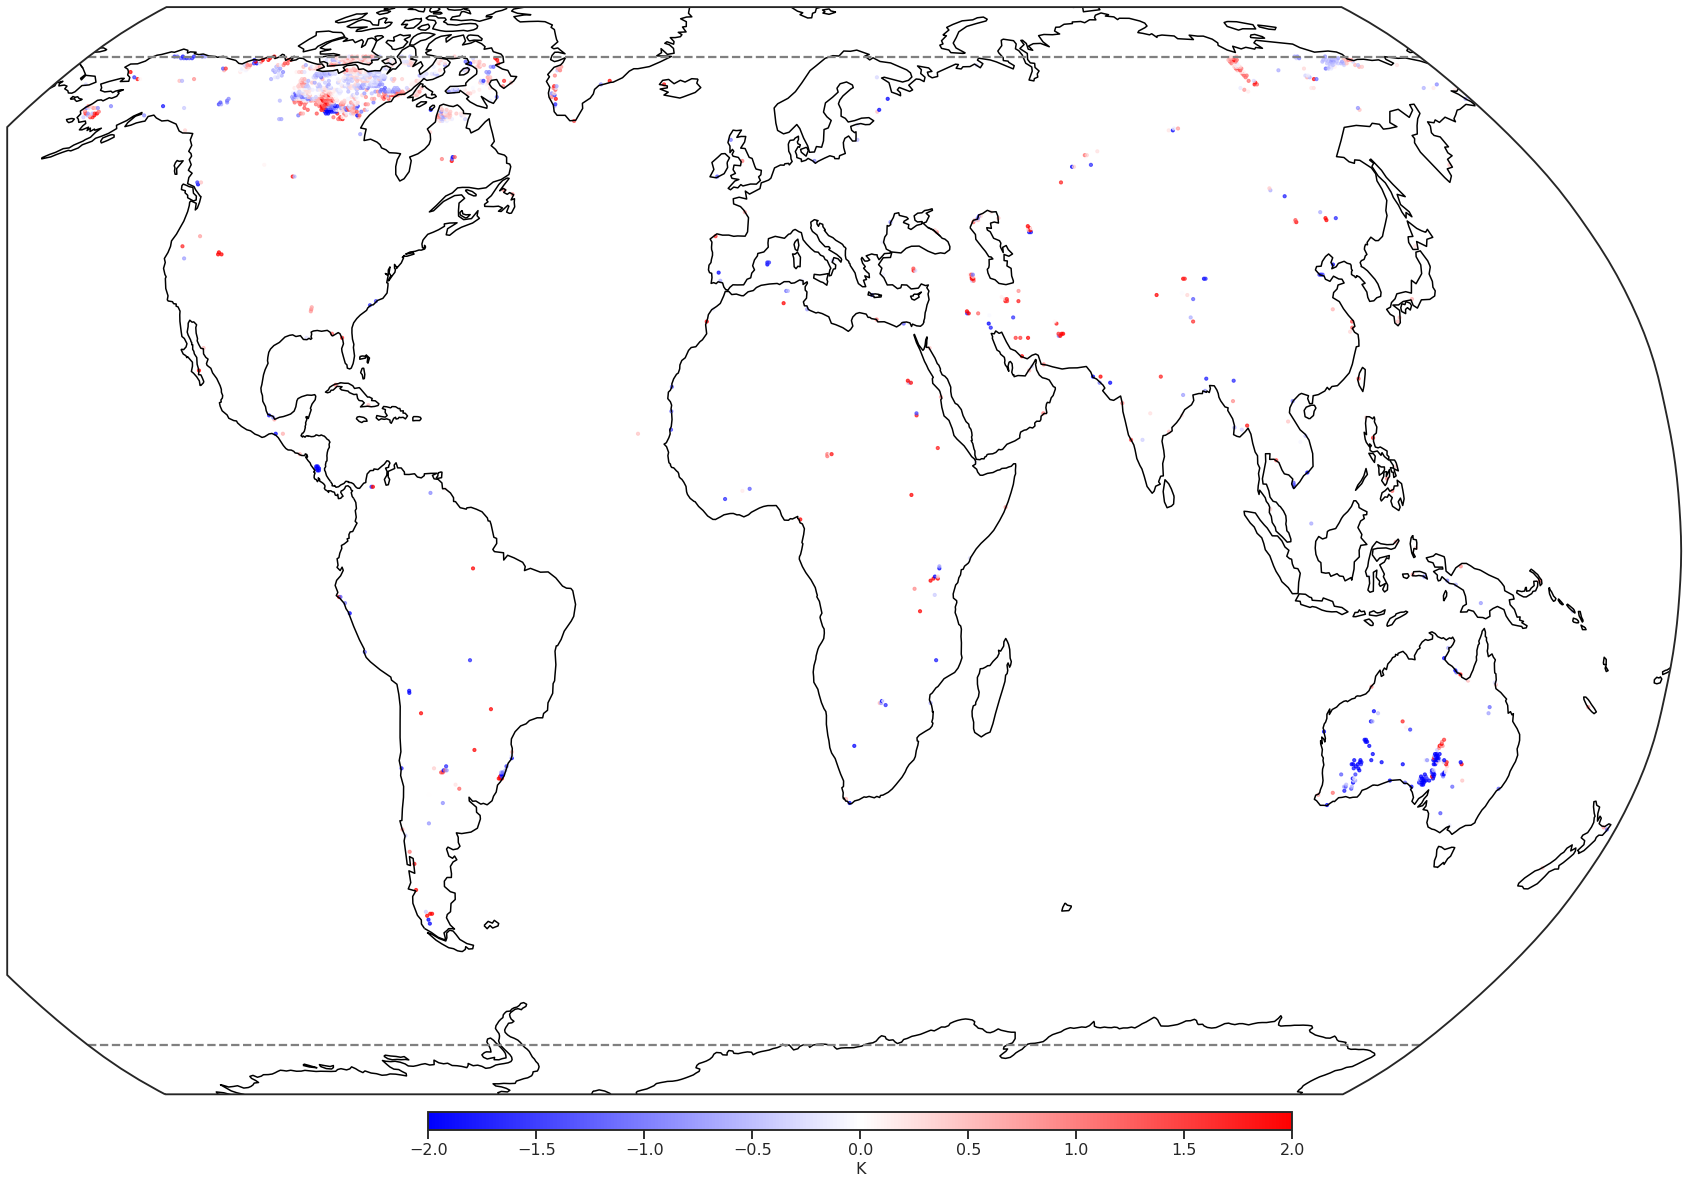

In [472]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.colors as mc
import matplotlib.colorbar as cb
import pandas as pd

dftmp = monthly_p01[['latitude_ERA', 'longitude_ERA', 'day','V20_error', 'V15_error']].copy()
dftmp['delta'] =dftmp.V20_error - dftmp.V15_error
ds_map = dftmp.groupby(['latitude_ERA', 'longitude_ERA','day'],as_index=False).mean()
ds_map['day_string'] = ds_map.day.astype(str)

display(ds_map)


# Data for plotting
t = np.unique(ds_map.day_string)
print(t)
frames = len(t)
markersize = 10

#Setup plotting env
fig = plt.figure(figsize=[30,20])
ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
cax = fig.add_axes([0.32, 0.10, 0.4, 0.0125])


cmap = plt.cm.bwr
norm = mc.Normalize(vmin=-2, vmax=+2)
cb1 = cb.ColorbarBase(cax, cmap=cmap,
                           norm=norm,
                           orientation='horizontal'
                           )



# titles = ['Jan 2019','Feb 2019','March 2019','Apr 2019','May 2019','Jun 2019',
#          'Jul 2019','Aug 2019','Sept 2019','Oct 2019','Nov 2019','Dec 2019']
    
    

def update(i):
    # clear the axis each frame
    ax.clear()
    
     
    #Get the data
    ti=t[i]
    condition = f"day_string == '{ti}'"
    ds = ds_map.query(condition)
    false_data = {'latitude_ERA':   [0.0,0.0] ,
                 'longitude_ERA': [-179.9,179.9],
                 'delta':          [0.0,0.0]}
    false_df = pd.DataFrame(false_data,index=[0,1]) #Forces plot to not attenuate at edges
    plotting_data = pd.concat([ds,false_df])
    
    
    
    #Get data
    x = ds['latitude_ERA']
    y = ds['longitude_ERA']
    z1 = ds['delta']
    
    

        
    
    # replot things
    sc = ax.scatter(y,x,transform=ccrs.PlateCarree(),
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)

    #title = titles[i]
    #print(title)
    #ax.set_title(title)

    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    #Formatting
    cax.tick_params(labelsize=16)
    cax.set_xlabel('K',fontsize=16)

    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio



# print('Animating')
ani = animation.FuncAnimation(fig, update, frames=frames, interval=500)
print('Saving')
ani.save('test2.mp4')










In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.colors as mc
import matplotlib.colorbar as cb
import pandas as pd

dftmp = monthly_p01[['latitude_ERA', 'longitude_ERA', 'month','V20_error', 'V15_error']].copy()
dftmp['delta'] =dftmp.V20_error - dftmp.V15_error
ds_map = dftmp.groupby(['latitude_ERA', 'longitude_ERA','month'],as_index=False).mean()



# Data for plotting
t = np.unique(ds_map.month)
frames = len(t)
markersize = 10

#Setup plotting env
fig = plt.figure(figsize=[30,20])
ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
cax = fig.add_axes([0.32, 0.10, 0.4, 0.0125])


cmap = plt.cm.bwr
norm = mc.Normalize(vmin=-2, vmax=+2)
cb1 = cb.ColorbarBase(cax, cmap=cmap,
                           norm=norm,
                           orientation='horizontal'
                           )



titles = ['Jan 2019','Feb 2019','March 2019','Apr 2019','May 2019','Jun 2019',
         'Jul 2019','Aug 2019','Sept 2019','Oct 2019','Nov 2019','Dec 2019']
    
    

def update(i):
    # clear the axis each frame
    ax.clear()
    
     
    #Get the data
    ti=t[i]
    condition = f"month == {ti}"
    ds = ds_map.query(condition)
    
    
    
    
    #Get data
    x = ds['latitude_ERA']
    y = ds['longitude_ERA']
    z1 = ds['delta']
    
    

        
    
    # replot things
    sc = ax.scatter(y,x,transform=ccrs.PlateCarree(),
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)

    title = titles[i]
    print(title)
    ax.set_title(title)

    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    #Formatting
    cax.tick_params(labelsize=16)
    cax.set_xlabel('K',fontsize=16)

    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio



# print('Animating')
ani = animation.FuncAnimation(fig, update, frames=frames, interval=500)
print('Saving')
ani.save('test.mp4')










# Appendix

In [413]:
V15_predictions,V15_predictions_averaged = load_predictions(V15_model)
V20_predictions,V20_predictions_averaged = load_predictions(V20_model)
V20X_predictions,V20X_predictions_averaged = load_predictions(V20_model_with_extras)

Mean/Median/Std prediction bias: -0.041747708 0.10055542 4.081224
Mean/Median/Std prediction error: 3.0393808 2.3208313 2.7240207
Mean/Median/Std prediction bias: 0.13015294 0.26712036 4.0542684
Mean/Median/Std prediction error: 3.0233936 2.3095398 2.7042806
Mean/Median/Std prediction bias: 0.018071566 0.15356445 3.9607246
Mean/Median/Std prediction error: 2.9511783 2.2535706 2.6416352


In [414]:
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_predictions_averaged.latitude_ERA, 
        'longitude_ERA':  V20_predictions_averaged.longitude_ERA,
        'MODIS_LST':      V20_predictions_averaged.MODIS_LST,
        'V15_prediction': V15_predictions_averaged.predictions,
        'V20_prediction': V20_predictions_averaged.predictions,
        'V15_error':      V15_predictions_averaged.predicion_error,
        'V20_error':      V20_predictions_averaged.predicion_error,
        'delta':          V20_predictions_averaged.predicion_error - V15_predictions_averaged.predicion_error}
V20_V15 = pd.DataFrame(data)    


In [415]:
p = 0.1
mask = change_in_fields.query(f'abs(change_in_cl) > {p}')

#Apply the mask to the global error_delta_field from earlier
V20_V15_masked = pd.merge(V20_V15,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

In [441]:
bit10 = V20_V15_masked.query('bitstring=="101100"')
x =bit10['V15_error'].values
y = bit10['V20_error'].values
display(bit10.sort_values(by=['delta']))

,latitude_ERA,longitude_ERA,MODIS_LST,V15_prediction,V20_prediction,V15_error,V20_error,delta,values,step,...,V15_dl,V20_dl,percentage_change_in_dl,cl_change_is_significant,si10_change_is_significant,cvh_change_is_significant,cvl_change_is_significant,lsm_change_is_significant,dl_change_is_significant,bitstring
4229,69.836018,-124.500000,262.706909,264.561462,262.181702,3.132460,2.845005,-0.287455,17396,0 days,...,25.0,8.154297,-0.673828,True,False,False,True,False,True,101100
4065,68.711899,-82.222222,260.665619,261.293121,260.023590,2.918608,3.085910,0.167302,19377,0 days,...,25.0,9.800781,-0.607969,True,False,False,True,False,True,101100
4150,69.273959,-93.000000,257.163452,257.806274,256.568970,3.109565,3.438165,0.328600,18398,0 days,...,25.0,10.000000,-0.600000,True,False,False,True,False,True,101100
4086,68.992929,-132.750000,265.609497,266.431580,266.972809,2.536222,2.962801,0.426579,18825,0 days,...,25.0,7.000000,-0.720000,True,False,False,True,False,True,101100
3410,63.934391,-90.000000,260.438751,260.418793,260.382141,2.598608,3.091508,0.492900,28618,0 days,...,25.0,12.132812,-0.514687,True,False,False,True,False,True,101100
4133,69.273959,-132.000000,264.736176,265.937744,262.660919,2.925280,3.610393,0.685113,18346,0 days,...,25.0,3.808594,-0.847656,True,False,False,True,False,True,101100
3276,62.810270,-92.250000,262.579620,261.656342,260.920441,2.549397,3.580859,1.031461,31044,0 days,...,25.0,28.157227,0.126289,True,False,False,True,False,True,101100
4006,68.149839,77.760000,265.037994,264.706268,262.853241,2.687000,3.733055,1.046055,20096,0 days,...,25.0,3.103516,-0.875859,True,False,False,True,False,True,101100


In [442]:
significance_test(x, y)

Ttest_indResult(statistic=-3.3043994483637684, pvalue=0.00521642231127351)

In [445]:
x

array([2.5493975, 2.598608 , 2.6869996, 2.918608 , 2.5362217, 2.9252796,
       3.1095653, 3.1324596], dtype=float32)

In [446]:
y

array([3.580859 , 3.0915077, 3.7330549, 3.0859096, 2.9628012, 3.6103926,
       3.438165 , 2.845005 ], dtype=float32)